---
title: "SWD Properties"
---

## Setup

In [16]:
#| hide
import polars as pl
import polars.selectors as cs
from loguru import logger

In [17]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Connect `python` with `R` kernel

In [18]:
from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

%load_ext rpy2.ipython

r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Processing datasets

In [19]:
ts = 1 # unit: seconds
tau = 60 # unit: seconds
data_dir = "../data"
format = "arrow"

In [20]:
parameters = ['j0_k', 'j0_k_norm',  'L_k', 'L_k_norm']

In [21]:
def load_events(name: str, ts: float, tau: float, method ='derivative') -> pl.DataFrame:
    if method == 'derivative':
        format = 'parquet'
        filepath = f"{data_dir}/08_reporting/events/l1/{name}_ts_{ts}s_tau_{tau}s.{format}"
        df = pl.scan_parquet(filepath)
    elif method == 'fit':
        format = 'arrow'
        filepath = f"{data_dir}/05_reporting/events.{name}.ts_{ts:.2f}s_tau_{tau}s.{format}"
        df = pl.read_ipc(filepath).lazy()
    return df.drop_nulls().with_columns(
        pl.col(parameters).abs(),
        sat = pl.lit(name),
        ts = pl.lit(f'{ts}s'),
        method = pl.lit(method),
        ts_method = pl.lit(f'{ts}s {method}'),
        label = pl.lit(f'{name} {ts}s {method}')
    ).collect()
    # .with_columns(cs.numeric().cast(pl.Float64))
    
wind_df = load_events('Wind', 1, 60, 'fit')
sta_df = load_events('STA', 1, 60, 'fit')
jno_df = load_events('JNO', 1, 60, 'fit')
jno_df_tau_300 = load_events('JNO', 1, 300, 'fit')

other_events = pl.concat([wind_df, sta_df], how='diagonal')

logger.info(f"Columns: {jno_df.columns}")

2024-02-17 15:14:51.677 | INFO     | __main__:<module>:27 - Columns: ['time', 'tstart', 'tstop', 'd_tstart', 'd_tstop', 'd_time', 'time_before', 'time_after', 'count', 'B_std', 'B_mean', 'dB_vec', 'index_diff', 'index_std', 'index_fluctuation', 'B.after', 'B.before', 'b_mag', 'b_n', 'bn_over_b', 'd_star', 'db_mag', 'db_over_b', 'db_over_b_max', 'fit.stat.chisqr', 'fit.stat.rsquared', 'fit.vars.amplitude', 'fit.vars.c', 'fit.vars.sigma', 'rotation_angle', 'dB_x', 'dB_y', 'dB_z', 'dB_lmn_x', 'dB_lmn_y', 'dB_lmn_z', 'k_x', 'k_y', 'k_z', 'Vl_x', 'Vl_y', 'Vl_z', 'Vn_x', 'Vn_y', 'Vn_z', 'duration', 'radial_distance', 'plasma_density', 'plasma_temperature', 'model_b_r', 'model_b_t', 'model_b_n', 'v_x', 'v_y', 'v_z', 'plasma_speed', 'B_background_x', 'B_background_y', 'B_background_z', 'v_x_before', 'v_y_before', 'v_z_before', 'n.before', 'v.ion.before', 'plasma_temperature_before', 'v_x_after', 'v_y_after', 'v_z_after', 'n.after', 'v.ion.after', 'plasma_temperature_after', 'v_l', 'v_n', 'v_k'

Some extreme values are present in the data. We will remove them.

In [22]:
DISPLAY_VARS = ['time', 'sat'] + parameters

def check_candidates(df):
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    logger.info(df.columns)
    return df.select(DISPLAY_VARS).describe()

check_candidates(jno_df)

2024-02-17 15:14:51.691 | INFO     | __main__:check_candidates:6 - ['time', 'tstart', 'tstop', 'd_tstart', 'd_tstop', 'd_time', 'time_before', 'time_after', 'count', 'B_std', 'B_mean', 'dB_vec', 'index_diff', 'index_std', 'index_fluctuation', 'B.after', 'B.before', 'b_mag', 'b_n', 'bn_over_b', 'd_star', 'db_mag', 'db_over_b', 'db_over_b_max', 'fit.stat.chisqr', 'fit.stat.rsquared', 'fit.vars.amplitude', 'fit.vars.c', 'fit.vars.sigma', 'rotation_angle', 'dB_x', 'dB_y', 'dB_z', 'dB_lmn_x', 'dB_lmn_y', 'dB_lmn_z', 'k_x', 'k_y', 'k_z', 'Vl_x', 'Vl_y', 'Vl_z', 'Vn_x', 'Vn_y', 'Vn_z', 'duration', 'radial_distance', 'plasma_density', 'plasma_temperature', 'model_b_r', 'model_b_t', 'model_b_n', 'v_x', 'v_y', 'v_z', 'plasma_speed', 'B_background_x', 'B_background_y', 'B_background_z', 'v_x_before', 'v_y_before', 'v_z_before', 'n.before', 'v.ion.before', 'plasma_temperature_before', 'v_x_after', 'v_y_after', 'v_z_after', 'n.after', 'v.ion.after', 'plasma_temperature_after', 'v_l', 'v_n', 'v_k', 

statistic,time,sat,j0_k,j0_k_norm,L_k,L_k_norm
str,str,str,f64,f64,f64,f64
"""count""","""63143""","""63143""",63143.0,63143.0,63143.0,63143.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0
"""mean""","""2013-05-14 11:…",null,125.040783,12.398706,9410.339035,45.121054
"""std""",null,null,12236.23217,1077.446348,5438.269571,34.72957
"""min""","""2011-08-25 16:…","""JNO""",0.000018,0.000036,1.187819,0.001187
"""25%""","""2012-03-08 20:…",null,0.124872,0.018557,5123.132655,20.526554
"""50%""","""2013-03-05 15:…",null,0.2963,0.046239,8643.437318,36.506577
"""75%""","""2014-03-11 18:…",null,0.748768,0.108717,12991.083881,59.95483
"""max""","""2016-06-29 23:…","""JNO""",2.4550e6,187435.626378,42775.89897,382.018872


In [23]:
def remove_extreme(df, cols = ['j0_k', 'L_k'], q = 0.96):
    filter_conditions = [
        pl.col(col) < pl.col(col).quantile(q) for col in cols
    ] + [
        pl.col(col) > pl.col(col).quantile(1-q) for col in cols
    ]
    
    return df.filter(filter_conditions)

def keep_good_fit(df: pl.DataFrame, rsquared = 0.95):
    return df.filter(pl.col('fit.stat.rsquared') > rsquared)

# jno_df = jno_df.pipe(remove_extreme).pipe(keep_good_fit)
# other_events = other_events.pipe(remove_extreme).pipe(keep_good_fit)
# jno_df_tau_300 = jno_df_tau_300.pipe(remove_extreme).pipe(keep_good_fit)

jno_df = jno_df.pipe(keep_good_fit)
other_events = other_events.pipe(keep_good_fit)
jno_df_tau_300 = jno_df_tau_300.pipe(keep_good_fit)

In [24]:
%R -i jno_df -c conv_pl
%R -i other_events -c conv_pl
%R -i jno_df_tau_300 -c conv_pl

In [25]:
%%R
p1title <- "a) Juno"
p2title <- "b) ARTEMIS, STEREO and Wind"
x_lab_r <- "Radial Distance (AU)"
x_lab_t <- "Time"

y_lab_t <- "Time Duration (s)"
y_lab_L <- "Log Thickness (km)"
y_lab_L_norm <- expression(Log~Thickness~(d[i]))

In [32]:
logger.info(f"Number of events > 5AU: {jno_df.filter(pl.col('radial_distance') > 4).height}")
logger.info(f"Number of events > 5AU: {jno_df.filter(pl.col('radial_distance') > 3, pl.col('radial_distance') < 4).height}")
logger.info(f"Number of events > 5AU: {jno_df_tau_300.filter(pl.col('radial_distance') > 4).height}")

2024-02-17 15:18:19.879 | INFO     | __main__:<module>:1 - Number of events > 5AU: 4207
2024-02-17 15:18:19.881 | INFO     | __main__:<module>:2 - Number of events > 5AU: 2033
2024-02-17 15:18:19.882 | INFO     | __main__:<module>:3 - Number of events > 5AU: 1035


Saving 13.8 x 7.09 in image
Saving 13.8 x 7.09 in image


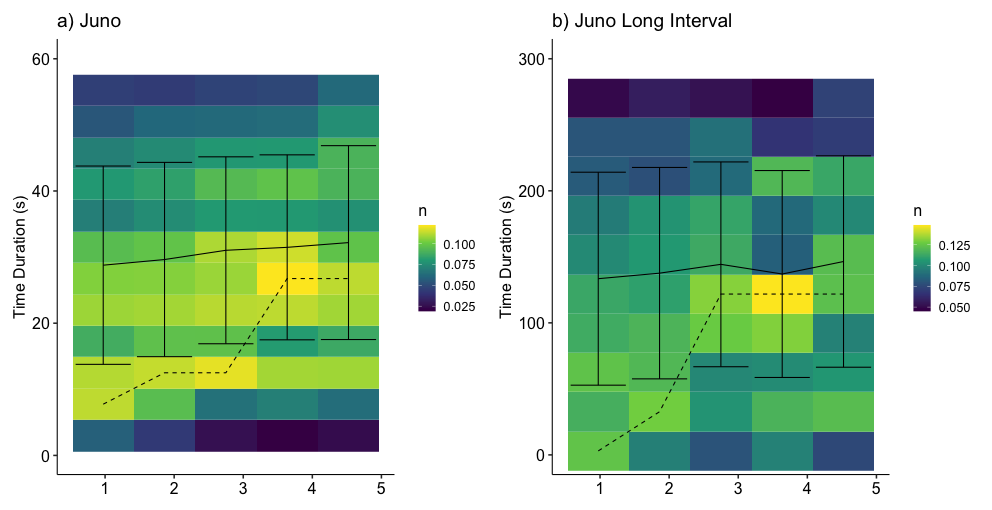

In [35]:
%%R -w 350 -h 180 -u mm
add_mode <- TRUE
x_bins <- 5
y_bins <- 12
log_y <- FALSE
y_lim_duration <- c(0.1, 60)

y_col <- "duration"
ylab <- y_lab_t

x_col <- "radial_distance"

p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins = y_bins, y_lim = y_lim_duration, log_y = log_y, add_mode=add_mode)
p1 <- p + labs(x = NULL, y= ylab) + ggtitle("a) Juno")

y_lim_duration <- c(0.1, 300)
y_bins <- 10
p <- plot_binned_data(jno_df_tau_300, x_col = x_col, y_col = y_col, x_bins = x_bins, y_bins = y_bins, y_lim = y_lim_duration, log_y = log_y, add_mode=add_mode)
p2 <- p + labs(x = NULL, y= ylab) + ggtitle("b) Juno Long Interval")

# p <- (p1 + p2) + plot_layout(ncol = 1, guides = "collect") & scale_fill_viridis_c(limits = c(0.01, 0.20), name="pdf")
p <- p1 + p2 
save_plot("new/duration/duration_dist")
p

In [13]:
%%R -w 350 -h 350 -u mm
layout <- plot_layout(ncol = 2, byrow = FALSE, guides = "collect")

add_mode <- FALSE
y_bins <- 24
y_lim_j0 <- c(0.03, 20)

x_col <- "radial_distance"

y_col <- "j0_k"
ylab <- expression(Log~J~(nA~m^-2))

# y_lim_j0 <- NULL
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim_j0, log_y = TRUE, add_mode=add_mode)
p1 <- p + labs(x = NULL, y= ylab) + ggtitle(p1title)
# save_plot("new/current/current_k_r_dist")


y_col <- "j0_k_norm"
y_lim_j0_norm <- c(0.002, 1)
ylab <- expression(Log~Normalized~J~(J[A]))
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim_j0_norm, log_y = TRUE, add_mode=add_mode)
p2 <- p + labs(x = x_lab_r, y= ylab)


x_col <- "time"

y_col <- "j0_k"
p <- plot_binned_data(other_events, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim_j0, log_y = TRUE, add_mode=add_mode)
p3 <- p + labs(x = NULL, y= NULL) + ggtitle(p2title)


y_col <- "j0_k_norm"
p <- plot_binned_data(other_events, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim_j0_norm, log_y = TRUE, add_mode=add_mode)
p4 <- p + labs(x = x_lab_t, y= NULL)

(p1 + p2 + p3 + p4) + layout & scale_fill_viridis_c(limits = c(0.01, 0.13), trans = "log10", name="pdf")
save_plot("new/current/current_k_dist")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image


In [14]:
%%R -w 350 -h 350 -u mm
x_col <- "radial_distance"
y_bins <- 16
add_mode <- FALSE

y_lim_L <- c(100, 40000)
y_lim_L_norm <- c(0.2, 200)
# y_lim_L <- NULL

## Panel 01
y_col <- "L_k_fit"

y_lim <- y_lim_L
ylab <- y_lab_L
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim, log_y = TRUE, add_mode=add_mode)
p1 <- p + labs(x = NULL, y= ylab) + ggtitle(p1title)

## Panel 02
y_col <- "L_k_fit_norm"


y_lim <- y_lim_L_norm
ylab <- y_lab_L_norm
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim, log_y = TRUE, add_mode=add_mode)
p2 <- p + labs(x = x_lab_r, y= ylab)

## Panel 03
x_col <- "time"
y_col <- "L_k_fit"
y_lim <- y_lim_L
p <- plot_binned_data(other_events, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim, log_y = TRUE, add_mode=add_mode)
p3 <- p + labs(x = NULL, y= NULL) + ggtitle(p2title)

## Panel 04
y_col <- "L_k_fit_norm"
y_lim <- y_lim_L_norm
p <- plot_binned_data(other_events, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = y_bins, y_lim = y_lim, log_y = TRUE, add_mode=add_mode)
p4 <- p + labs(x = x_lab_t, y= NULL)

(p1 + p2 + p3 + p4) + layout & scale_fill_viridis_c(limits = c(0.01, 0.18), trans = "log10", name="pdf")
save_plot("new/thickness/thickness_k_fit_dist")


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 13.8 x 13.8 in image
Saving 13.8 x 13.8 in image


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


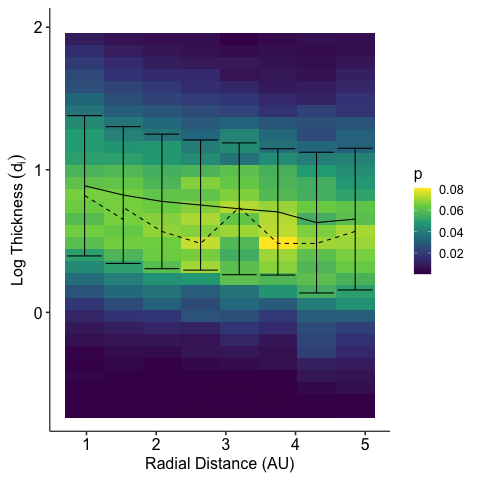

In [40]:
%%R
x_col <- "radial_distance"
xlab <- "Radial Distance (AU)"

y_col <- "L_k_fit"
ylab <- "Log Thickness (km)"
y_lim <- c(100, 40000)
# y_lim <- NULL
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
# save_plot("new/thickness/thickness_k_fit_r_dist")

y_col <- "L_k_fit_norm"
y_lim <- c(0.2, 100)
# y_lim <- NULL
ylab <- expression(Log~Thickness~(d[i]))
p <- plot_binned_data(jno_df, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("new/thickness/thickness_k_fit_N1_r_dist")
p